## Imports

In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.utils import plot_model
from keras.regularizers import l2
import os
import cv2
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False


### Funciones auxiliares

In [2]:
def mass_center(image):
  """
  Esta funcion calcula el centro de masa de un arreglo bidimensional de numpy
  INPUT:
  image: array [i,j].

  OUTPUT:
  (x,y) . Pixel donde esta el centro de masa
  """
  x = np.arange(0, image.shape[1], 1)
  y = np.arange(0, image.shape[0], 1)
  xv, yv = np.meshgrid(x, y)

  xc = np.sum(image*xv)/np.sum(image)
  yc = np.sum(image*yv)/np.sum(image)

  return (np.around(xc),np.around(yc))
def shift_to_center(image):
  x_l = image.shape[1]
  y_l = image.shape[0]


  # Centro de la imagen
  x_centro = np.floor(x_l/2)
  y_centro = np.floor(y_l/2)

  # Centro de mas del numero
  xi,yi = mass_center(image)

  try:
    dx = int(x_centro - xi)
    dy = int(y_centro - yi)

  except:
    # Si no se puede calcular, entonces no mover
    return image


  shift_image = np.zeros_like(image)
  #print(f"centro de masa: {xi},{yi}")
  #print(f"centro de imagen: {x_centro},{y_centro}")
  #print(f"dx: {dx}")
  #print(f"dy: {dy}")
  # Desplazamos la imagen
  if (dy>=0) and (dx>=0):
    dx = abs(dx)
    dy = abs(dy)
    shift_image[dy:,dx:] = image[0:y_l-dy,0:x_l-dx]
  if (dy>=0) and (dx<0):
    dx = abs(dx)
    dy = abs(dy)
    shift_image[dy:,0:x_l-dx] = image[0:y_l-dy,dx:]
  if (dy<0) and (dx>=0):
    dx = abs(dx)
    dy = abs(dy)
    shift_image[0:y_l-dy,dx:] = image[dy:,0:x_l-dx]
  if (dy<0) and (dx<0):
    dx = abs(dx)
    dy = abs(dy)
    shift_image[0:y_l-dy,0:x_l-dx] = image[dy:,dx:]

  return shift_image
def draw_box_size(image):
    """
    Esta funcion calcula el tamaño del cuadro que contiene al numero
    INPUT:
    image: array [i,j].

    OUTPUT:
    (ancho,alto) . Pixel donde esta el centro de masa
    """
    # Encuentra la primera linea de afuera hacia adentro
    size = len(image)
    for i in range(int(size/2)):
        if any(image[i,:]) or any(image[size - 1 - i,:]) or any(image[:,i]) or any(image[:,size - 1 - i]):
          size_draw = size -i*2 #
          return size_draw
    return 28
def zoom_centro(matriz):
    """
    Ya que los usuarios no siempre dibujan en el mismo tamaño, esta funcion escala el dibujo
    para que ocupe todo el espacio de la imagen asumiendo que el dibujo esta centrado en la imagen.
    Manteniendo la proporcion de la imagen.
    """
    escala = draw_box_size(matriz)/28 # 26 para no ocupar todo el espacio

    # Obtén las dimensiones originales
    alto, ancho = matriz.shape

    # Calcula las nuevas dimensiones después del zoom
    nuevo_alto = int(alto * escala)
    nuevo_ancho = int(ancho * escala)

    # Calcula el desplazamiento necesario para centrar la matriz en la imagen zoomed
    desplazamiento_alto = (nuevo_alto - alto) // 2
    desplazamiento_ancho = (nuevo_ancho - ancho) // 2

    # Crea una matriz vacía con las nuevas dimensiones
    matriz_zoomed = np.zeros((nuevo_alto, nuevo_ancho), dtype=matriz.dtype)

    # Calcula las regiones a copiar desde la matriz original
    inicio_alto = max(0, -desplazamiento_alto)
    fin_alto = min(alto, nuevo_alto - desplazamiento_alto)
    inicio_ancho = max(0, -desplazamiento_ancho)
    fin_ancho = min(ancho, nuevo_ancho - desplazamiento_ancho)

    # Copia la región de la matriz original a la matriz zoomed
    matriz_zoomed[desplazamiento_alto + inicio_alto:desplazamiento_alto + fin_alto,
                  desplazamiento_ancho + inicio_ancho:desplazamiento_ancho + fin_ancho] = \
        matriz[inicio_alto:fin_alto, inicio_ancho:fin_ancho]

    # Aplica la interpolación para suavizar la imagen zoomed
    matriz_zoomed = cv2.resize(matriz_zoomed, (ancho, alto), interpolation=cv2.INTER_LINEAR)

    return matriz_zoomed
def process_all_images(X):
  new_X = []
  kernel = np.ones((2,2), np.uint8)
  for x in X:
    newx = shift_to_center(x)
    newx = zoom_centro(newx)
    #newx = cv2.erode(newx, kernel, iterations=1)
    new_X.append(newx)

  return np.array(new_X)

## Load Data

In [3]:
if IN_COLAB:
    from google.colab import files
    uploaded = files.upload()
    Data = np.load('/content/MNIST_UIS.npz')
    Data_clean = np.load('/content/MNIST_UIS2.npz')
else:
    Data = np.load('data/MNIST_UIS.npz')
    Data_clean = np.load('data/MNIST_UIS2.npz')

In [4]:
#Datos
X_train_uis = Data['X_train_uis']
X_test_uis = Data['X_test_uis']
y_train_uis = Data['y_train_uis']
y_test_uis = Data['y_test_uis']

# Datos limpios
X_train_uis_C = Data_clean['X_train_uis']
X_test_uis_C = Data_clean['X_test_uis']
y_train_uis_C = Data_clean['y_train_uis']
y_test_uis_C = Data_clean['y_test_uis']

C:\Users\User\AppData\Local\Temp\ipykernel_23476\560265279.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x="Digit", y="Count", data=data, palette="viridis", edgecolor="black")


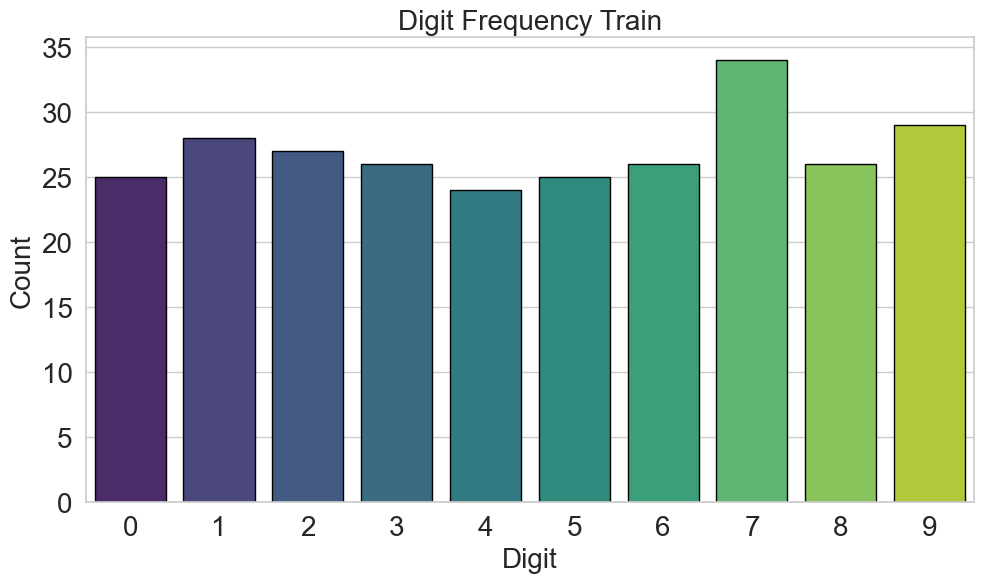

C:\Users\User\AppData\Local\Temp\ipykernel_23476\560265279.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x="Digit", y="Count", data=data, palette="viridis", edgecolor="black")


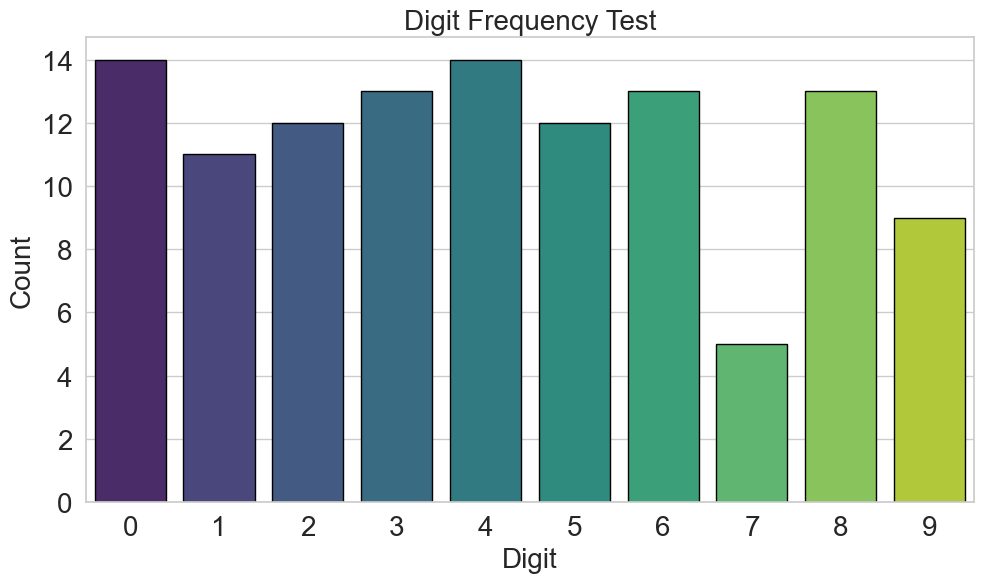

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Count the occurrences of each digit
unique, counts = np.unique(y_train_uis_C, return_counts=True)

# Create a DataFrame for easier data handling in Seaborn
import pandas as pd
data = pd.DataFrame({'Digit': unique, 'Count': counts})

# Seaborn style configuration
sns.set_theme(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Digit", y="Count", data=data, palette="viridis", edgecolor="black")

# Add labels and title
plt.title("Digit Frequency Train", fontsize=20)
plt.xlabel("Digit", fontsize=20)
plt.ylabel("Count", fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=20)  # Cambia '16' por el tamaño de fuente deseado

# Improve layout
plt.tight_layout()
plt.show()
##################################
unique, counts = np.unique(y_test_uis_C, return_counts=True)
data = pd.DataFrame({'Digit': unique, 'Count': counts})

# Seaborn style configuration
sns.set_theme(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Digit", y="Count", data=data, palette="viridis", edgecolor="black")

# Add labels and title
plt.title("Digit Frequency Test", fontsize=20)
plt.xlabel("Digit", fontsize=20)
plt.ylabel("Count", fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=20)  # Cambia '16' por el tamaño de fuente deseado
# Improve layout
plt.tight_layout()
plt.show()




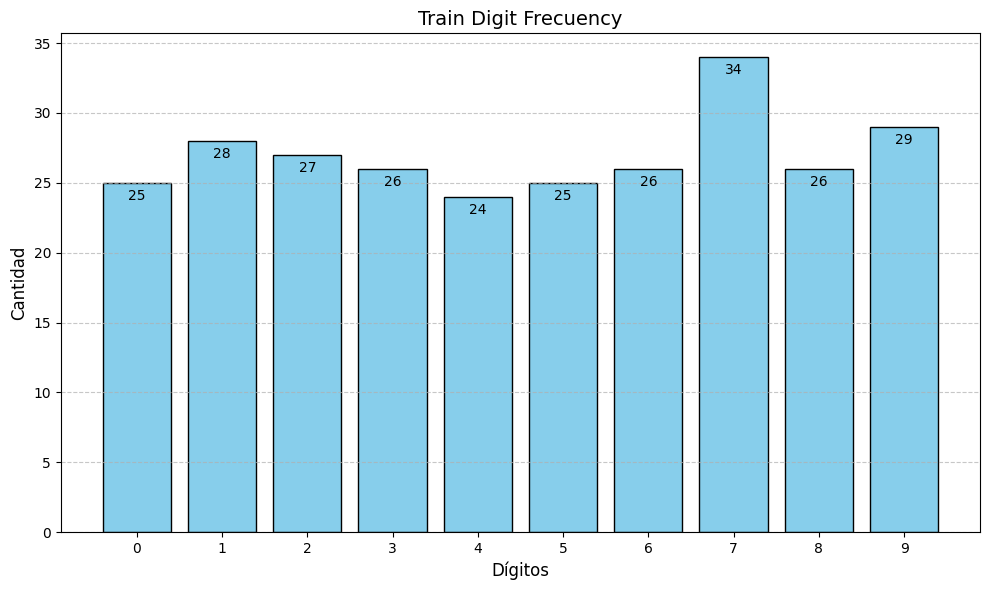

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que tienes el array y_train_uis_C
# Ejemplo: y_train_uis_C = np.array([0, 1, 2, 3, 1, 2, 2, 3, 4, 4, 0, 9])

# Contar las ocurrencias de cada dígito (0 a 9)
unique, counts = np.unique(y_train_uis_C, return_counts=True)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Dígitos', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.title('Train Digit Frecuency', fontsize=14)
plt.xticks(unique, fontsize=10)
plt.yticks(fontsize=10)

# Mostrar los valores encima de las barras
for i, count in zip(unique, counts):
    plt.text(i, count - 1.2, str(count), ha='center', fontsize=10)

# Mostrar el gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


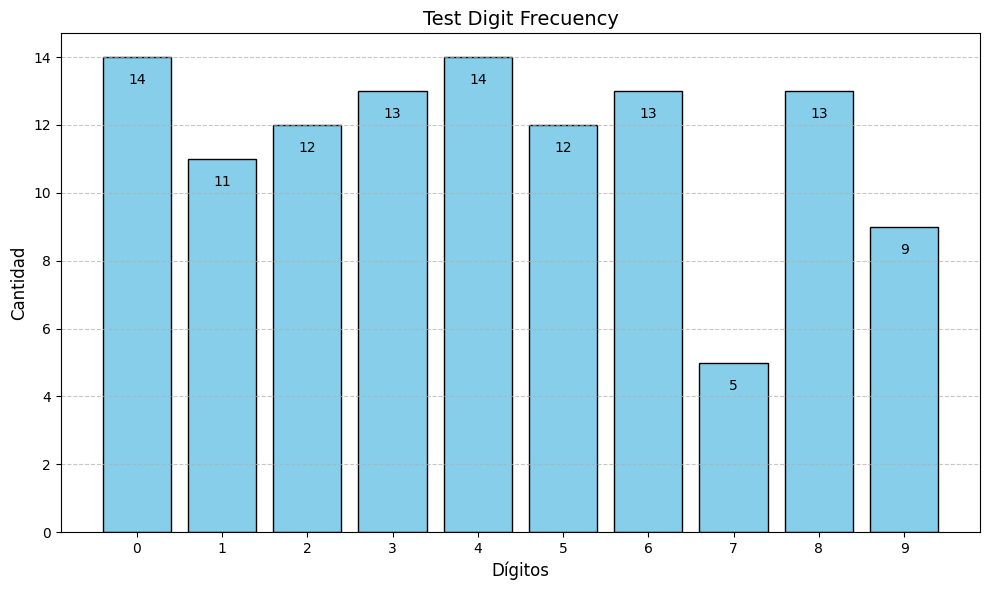

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que tienes el array y_train_uis_C
# Ejemplo: y_train_uis_C = np.array([0, 1, 2, 3, 1, 2, 2, 3, 4, 4, 0, 9])

# Contar las ocurrencias de cada dígito (0 a 9)
unique, counts = np.unique(y_test_uis_C, return_counts=True)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Dígitos', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.title('Test Digit Frecuency', fontsize=14)
plt.xticks(unique, fontsize=10)
plt.yticks(fontsize=10)

# Mostrar los valores encima de las barras
for i, count in zip(unique, counts):
    plt.text(i, count -0.8, str(count), ha='center', fontsize=10)

# Mostrar el gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [5]:
y_train = y_train_uis_C
y_test = y_test_uis_C

X_train = process_all_images(X_train_uis_C)
X_test = process_all_images(X_test_uis_C)

# Normalizing the data
x_mean = np.mean(X_train)
x_std = np.std(X_train)

X_train = (X_train-x_mean)/x_std
X_test = (X_test-x_mean)/x_std

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")


# Transforming the labels to hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

## Model Architecture

In [6]:
input_layer = keras.Input(shape=(28, 28,1))

# Primera capa convolucional
x = layers.Conv2D(128, (3, 3), activation='relu')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.1)(x)

# Segunda capa convolucional
x = layers.Conv2D(80, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.1)(x)

# Reducción espacial
#x = layers.MaxPooling2D()(x)

# Capas totalmente conectadas
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.1)(x)  # Ajusta según sea necesario

# Salida
y_out = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=y_out)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 80)     │        92,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 80)     │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       256,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,770 (1.34 MB)

 Trainable params: 351,354 (1.34 MB)

 Non-trainable params: 416 (1.62 KB)

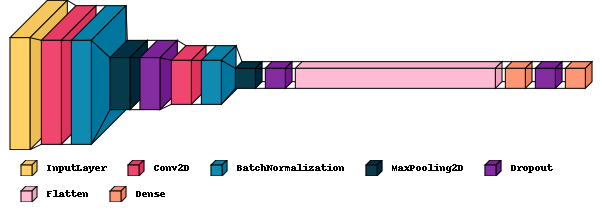

In [13]:
import visualkeras
visualkeras.layered_view(model, legend=True,draw_volume=True, to_file='images/model.png')


## Compilation and train

In [7]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)
# Compile and train

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


history = model.fit(X_train, y_train, batch_size=64, epochs=200, callbacks=[callback], validation_split=0.1)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.2399 - loss: 5.5756 - val_accuracy: 0.4444 - val_loss: 4.4266
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7560 - loss: 3.0772 - val_accuracy: 0.8519 - val_loss: 4.2089
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8638 - loss: 2.7409 - val_accuracy: 0.7778 - val_loss: 3.9916
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9512 - loss: 2.5081 - val_accuracy: 0.8519 - val_loss: 3.8147
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9718 - loss: 2.3823 - val_accuracy: 0.9630 - val_loss: 3.6240
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9606 - loss: 2.3199 - val_accuracy: 1.0000 - val_loss: 3.4821
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9914 - loss: 2.2047 - val_accuracy: 1.0000 - val_loss: 3.3540
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9926 - loss: 2.1454 - val_accuracy: 0.8519 - val_loss

### Test

In [8]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Loss on the test", score[0])
print("Accuracy on the test", score[1])

Loss on the test 0.1063130795955658
Accuracy on the test 0.9741379022598267


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


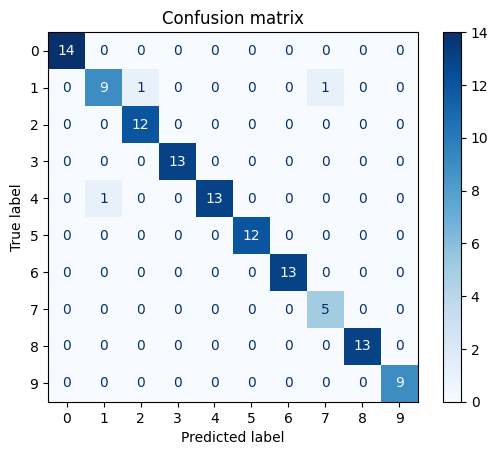

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtén las predicciones del modelo en los datos de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convierte las predicciones en etiquetas de clase
y_true = np.argmax(y_test, axis=1)  # Convierte las etiquetas reales en índices si están en formato one-hot

# Calcula la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Visualiza la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.show()


## Export model

In [ ]:
model.save("model/modelo.h5")